In [1]:
from sklearn.model_selection import train_test_split
import os
import glob
import cv2
import numpy as np # linear algebra
from skimage.io import imread
from skimage.io import imsave
from imageio import imwrite
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
data_dir = '/mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/'
train_image_dir = os.path.join(data_dir, 'train')
val_image_dir = os.path.join(data_dir, 'val')
import gc; gc.enable() # memory is tight
from skimage.morphology import label

In [2]:
BATCH_SIZE = 25
EDGE_CROP = 2
NB_EPOCHS = 20
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'DECONV'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
#IMG_SCALING = (1, 1)
IMG_SCALING = None
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [3]:
def get_all_imgs():
    img_path = os.path.join(train_image_dir,'annotations')
    images = glob.glob(os.path.join(img_path,'1*.*'))
    return [image.split('/')[-1] for image in images]

In [4]:
# print(get_all_imgs())
TRAIN_IMGS, TEST_IMGS = train_test_split(get_all_imgs())
#print(len(TRAIN_IMGS))
#print(len(TEST_IMGS))

24892
8298


In [5]:
import random
def cv2_brightness_augment(img):
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    seed = random.uniform(0.5,1.2)
    v = (( v/255.0 ) * seed)*255.0
    hsv[:,:,2] = np.array(np.clip(v,0,255),dtype=np.uint8)
    rgb_final = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return rgb_final

In [6]:
def make_image_gen(img_file_list=TRAIN_IMGS, batch_size = BATCH_SIZE):
    all_batches = TRAIN_IMGS
    out_rgb = []
    out_mask = []
    out_classes = []
    img_path = os.path.join(train_image_dir,'images')
    mask_path = os.path.join(train_image_dir,'annotations')
    while True:
        #I Think tha this is slow, comment and generate the random shuffle in main init call
        #np.random.shuffle(all_batches)
        for c_img_id in all_batches:
            c_img_name_split = c_img_id.split('_')
            c_img_class = c_img_id.split('-')[1]
            c_img_name = c_img_id.split('-')[0] + "."  + c_img_id.split('-')[2].split('.')[1]
            c_img = imread(os.path.join(img_path,c_img_name))
            c_img = cv2_brightness_augment(c_img)
            c_mask = imread(os.path.join(mask_path,c_img_id))
            if IMG_SCALING is not None:
                c_img = cv2.resize(c_img,(256,256),interpolation = cv2.INTER_AREA)
                c_mask = cv2.resize(c_mask,(256,256),interpolation = cv2.INTER_AREA)
            c_mask = np.reshape(c_mask,(c_mask.shape[0],c_mask.shape[1],-1))
            c_mask = c_mask > 0
            out_rgb += [c_img]
            out_mask += [c_mask]
            out_classes += [c_img_class]
            if len(out_mask)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0), out_classes
                out_rgb, out_mask, out_classes=[], [], []

In [7]:
#np.random.shuffle(TRAIN_IMGS)
train_gen = make_image_gen()
train_x, train_y, img_class = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())
print(img_class)

('x', (25, 720, 1280, 3), 0.0, 1.0)
('y', (25, 720, 1280, 1), False, True)
['purple_dish', 'red_spoon', 'blue_dish', 'yellow_glass', 'purple_spoon', 'purple_spoon', 'orange_glass', 'purple_bowl', 'green_dish', 'orange_glass', 'green_knife', 'red_spoon', 'purple_bowl', 'yellow_glass', 'purple_spoon', 'red_knife', 'purple_dish', 'blue_fork', 'yellow_dish', 'red_bowl', 'red_bowl', 'green_fork', 'yellow_dish', 'purple_bowl', 'orange_fork']


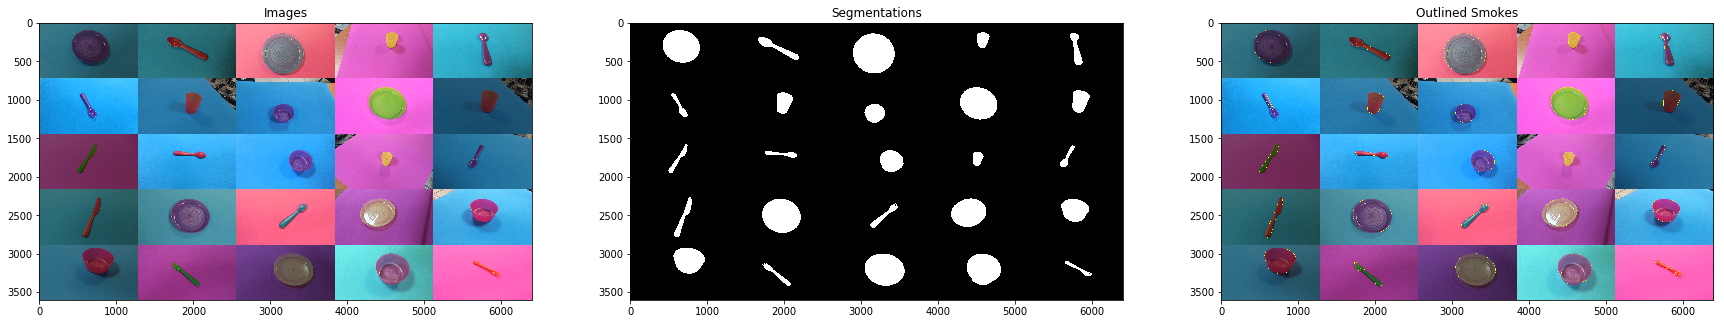

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg, cmap='gray')
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Smokes')
fig.savefig('overview.png')

In [9]:
#valid_x, valid_y, valid_class = next(make_image_gen(TEST_IMGS,len(TEST_IMGS)))
#print(valid_x.shape, valid_y.shape, valid_class)
val_gen = make_image_gen(TEST_IMGS, BATCH_SIZE)

In [10]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 60, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.7, 1.75],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'constant',
                  data_format = 'channels_last',
                  validation_split=0.2)
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y, in_class in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=False)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=False)

        yield next(g_x)/255.0, next(g_y), in_class

Using TensorFlow backend.


In [ ]:
cur_gen = create_aug_gen(train_gen)
count = 0

t_x = []
t_y = []
in_class = []
initCount = 2000000

img_path = os.path.join(train_image_dir,'images')
mask_path = os.path.join(train_image_dir,'annotations')

while True:
#hile initCount == 2000000:
    try:
        t_x, t_y, in_classes = next(cur_gen)
        #print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
        #print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
        #print(in_classes)
        for index in range(len(t_x)):
            imsave(os.path.join(img_path, str(initCount) + ".png"), t_x[index])
            imsave(os.path.join(mask_path, str(initCount) + "-" + in_classes[index] + "-0.png"),t_y[:, :, :, 0][index])
            #imwrite(os.path.join(img_path, str(initCount) + ".png"), t_x[index])
            #imwrite(os.path.join(mask_path, str(initCount) + "-" + in_classes[index] + "-0.png"),t_y[:, :, :, 0][index])
            initCount += 1
            #imsave("",t_x[0])
        gc.collect()
    except StopIteration:
        break
#t_x, t_y = next(cur_gen)
#print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
#print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
#print(len(t_x))
#print(len(t_y))
#print(len(t_y[:, :, :, 0][0]))
#t_x = t_x[:9]
#t_y = t_y[:9]
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
#ax1.imshow(montage_rgb(t_x), cmap='gray')
#ax1.set_title('images')
#ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray')
#ax2.set_title('smoke')
#fig.savefig('augmentations.png')
#cur_gen = create_aug_gen(train_gen)
#t_x, t_y = next(cur_gen)
#print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
#print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
#print(len(t_x))
#print(len(t_y))
#print(len(t_y[:, :, :, 0][0]))
#t_x = t_x[:9]
#t_y = t_y[:9]
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
#ax1.imshow(montage_rgb(t_x), cmap='gray')
#ax1.set_title('images2')
#ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray')
#ax2.set_title('smoke2')
#fig.savefig('augmentations.png')

In [ ]:
gc.collect()

In [ ]:
cur_gen = create_aug_gen(val_gen)
count = 0

v_x = []
v_y = []
in_class = []

initCount = 2000000

img_path = os.path.join(val_image_dir,'images')
mask_path = os.path.join(val_image_dir,'annotations')

while True:
#hile initCount == 2000000:
    try:
        v_x, v_y, in_classes = next(cur_gen)
        #print('x', v_x.shape, v_x.dtype, v_x.min(), v_x.max())
        #print('y', v_y.shape, v_y.dtype, v_y.min(), v_y.max())
        #print(in_classes)
        for index in range(len(v_x)):
            imsave(os.path.join(img_path, str(initCount) + ".png"), v_x[index])
            imsave(os.path.join(mask_path, str(initCount) + "-" + in_classes[index] + "-0.png"),v_y[:, :, :, 0][index])
            initCount += 1
            #imsave("",t_x[0])
        gc.collect()
    except StopIteration:
        break

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2000016-blue_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2000029-red_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2000045-blue_fork-0.png is a low contrast image
  warn('%s is a low contrast image

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2000362-purple_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2000365-blue_spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2000373-red_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2000734-red_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2000738-orange_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2000754-red_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/20

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2001077-green_spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2001078-red_spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2001090-purple_spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2001413-purple_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2001460-purple_spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2001501-purple_glass-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotatio

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2001862-orange_spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2001878-blue_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2001882-blue_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2002228-blue_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2002243-red_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2002263-purple_spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2002653-purple_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2002682-orange_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2002704-orange_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotatio

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2002977-red_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2003008-red_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2003018-red_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/200305

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2003384-red_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2003397-red_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2003400-purple_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2003

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2003701-red_spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2003705-red_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2003706-purple_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/200

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2004093-orange_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2004111-red_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2004141-purple_spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2004547-orange_spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2004557-red_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2004573-purple_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2004912-purple_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2004920-purple_glass-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2004938-purple_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotation

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2005262-red_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2005276-yellow_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2005297-purple_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2005780-red_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2005790-blue_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2005791-red_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/200584

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2006226-green_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2006227-purple_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2006245-purple_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotation

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2006601-purple_spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2006606-blue_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2006632-orange_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotation

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2007056-red_spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2007081-orange_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2007086-orange_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2007461-purple_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2007464-red_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2007466-green_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2007842-red_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2007861-purple_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2007877-red_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2007

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2008184-blue_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2008194-blue_knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2008199-orange_spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/

/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2008650-red_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2008658-yellow_fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/tableware/val/annotations/2008670-red_spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
